In [1]:
import pandas as pd

base_dir = '/kaggle/input/skin-cancer-mnist-ham10000/'
train_df = pd.read_csv(base_dir + 'HAM10000_metadata.csv')
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [2]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import os
from keras import layers
from keras.models import Sequential
from keras.layers import Dense ,Conv2D, MaxPooling2D, Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import AlphaDropout
from keras.layers import GaussianNoise
from keras.layers import Add, AveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras import losses
from keras import Model
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import zoom
from tensorflow.keras import activations
from keras.callbacks import ReduceLROnPlateau

In [3]:
from keras.losses import CategoricalCrossentropy

laloss = CategoricalCrossentropy(label_smoothing=0.6)

In [4]:
train_df = pd.read_csv(base_dir + 'HAM10000_metadata.csv')
train_df.drop(["lesion_id"],axis = 1)
train_df.drop(["dx_type"],axis = 1)

from sklearn.preprocessing import OneHotEncoder
encDX = OneHotEncoder(handle_unknown='ignore')
y_categorical = encDX.fit_transform(np.array(train_df["dx"]).reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(train_df, y_categorical, test_size = 0.1, random_state = 42, shuffle = True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2.0/9.0, random_state = 42, shuffle = True)


del train_df

x_trainImg = np.zeros((7010,45,60,3),dtype = np.uint8)
x_valImg = np.zeros((2003,45,60,3),dtype = np.uint8)
#x_testImg = np.zeros((1002,225,300,3),dtype = np.uint8)

a = 0

for i in x_train["image_id"].values:
    if i + '.jpg' in os.listdir(base_dir + 'HAM10000_images_part_2/'):
        x_trainImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_2/' + i + '.jpg'),[0.1,0.1,1]))
    else:
        x_trainImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_1/' + i + '.jpg'),[0.1,0.1,1]))
    a+=1
    if a%1000 == 0:
        print(a/1000)

a = 0        
        
for i in x_val["image_id"].values:
    if i + '.jpg' in os.listdir(base_dir + 'HAM10000_images_part_2/'):
        x_valImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_2/' + i + '.jpg'),[0.1,0.1,1]))
    else:
        x_valImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_1/' + i + '.jpg'),[0.1,0.1,1]))
    a+=1
    if a%1000 == 0:
        print(a/1000)

a = 0 


media = np.mean(x_trainImg)
desvio = np.std(x_trainImg)

x_trainImg = (x_trainImg - media)/desvio
x_valImg = (x_valImg - media)/desvio
#x_testImg = (x_testImg - media)/desvio

x_trainAge = x_train["age"]

media = np.mean(x_trainAge)
desvio = np.std(x_trainAge)

x_trainAge = (x_trainAge - media)/desvio
x_valAge = (x_val["age"] - media)/desvio
x_testAge = (x_test["age"] - media)/desvio

encGen = OneHotEncoder(handle_unknown='ignore')
x_trainGen = encGen.fit_transform(np.array(x_train["sex"].tolist()).reshape(-1, 1))
x_valGen = encGen.transform(np.array(x_val["sex"].tolist()).reshape(-1, 1))
x_testGen = encGen.transform(np.array(x_test["sex"].tolist()).reshape(-1, 1))

encLoc = OneHotEncoder(handle_unknown='ignore')
x_trainLoc = encLoc.fit_transform(np.array(x_train["localization"].tolist()).reshape(-1, 1))
x_valLoc = encLoc.transform(np.array(x_val["localization"].tolist()).reshape(-1, 1))
x_testLoc = encLoc.transform(np.array(x_test["localization"].tolist()).reshape(-1, 1))

1.0
2.0
3.0
4.0
5.0
6.0
7.0
1.0
2.0


Probamos los resultados en validation sin metadatos para notar el aporte de la imagen a la red.

# Modelos de AlexNET

In [5]:
imagen = layers.Input((45, 60, 3),name='imagen')

net = Conv2D(filters=16, kernel_size=(11, 11),strides = 4, padding='same')(imagen)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), padding='same')(net)

net = Conv2D(filters=32, kernel_size=(5, 5),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Conv2D(filters=64, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=64, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=32, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Flatten()(net)

net = Dense(units=256, activation='relu')(net)
net = Dropout(0.1)(net)
net = Dense(units=128, activation='relu')(net)
net = Dropout(0.1)(net)
net = Dense(units=7, activation='softmax')(net)

model = Model(inputs = imagen, outputs = net)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imagen (InputLayer)          [(None, 45, 60, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 12, 15, 16)        5824      
_________________________________________________________________
activation (Activation)      (None, 12, 15, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 5, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 5, 32)          12832     
_________________________________________________________________
activation_1 (Activation)    (None, 4, 5, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 3, 32)          0     

In [6]:
from keras.optimizers import Adam 
opt = Adam(learning_rate = 0.1)

model.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])

callback = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, min_lr=0.00001)

hist = model.fit({'imagen':x_trainImg},y_train.toarray(),batch_size = 5, validation_data = (x_valImg,y_val.toarray()),epochs = 100,
                 callbacks = [callback])

Epoch 1/100
1402/1402 [==============================] - 6s 4ms/step - loss: 1.7801 - accuracy: 0.6770 - val_loss: 1.7665 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 2/100
1402/1402 [==============================] - 6s 4ms/step - loss: 1.7652 - accuracy: 0.6971 - val_loss: 1.7741 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 3/100
1402/1402 [==============================] - 6s 4ms/step - loss: 1.7599 - accuracy: 0.7040 - val_loss: 1.7660 - val_accuracy: 0.7004 - lr: 0.0010
Epoch 4/100
1402/1402 [==============================] - 6s 4ms/step - loss: 1.7569 - accuracy: 0.7100 - val_loss: 1.7542 - val_accuracy: 0.7034 - lr: 0.0010
Epoch 5/100
1402/1402 [==============================] - 6s 4ms/step - loss: 1.7537 - accuracy: 0.7194 - val_loss: 1.7549 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 6/100
1402/1402 [==============================] - 7s 5ms/step - loss: 1.7515 - accuracy: 0.7227 - val_loss: 1.7574 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 7/100
1402/1402 [=============================

1402/1402 [==============================] - 6s 4ms/step - loss: 1.6574 - accuracy: 0.9238 - val_loss: 1.7871 - val_accuracy: 0.6915 - lr: 1.0000e-04
Epoch 53/100
1402/1402 [==============================] - 6s 4ms/step - loss: 1.6562 - accuracy: 0.9251 - val_loss: 1.7864 - val_accuracy: 0.6985 - lr: 1.0000e-04
Epoch 54/100
1402/1402 [==============================] - 6s 4ms/step - loss: 1.6555 - accuracy: 0.9278 - val_loss: 1.7849 - val_accuracy: 0.7019 - lr: 1.0000e-04
Epoch 55/100
1402/1402 [==============================] - 6s 4ms/step - loss: 1.6544 - accuracy: 0.9317 - val_loss: 1.7863 - val_accuracy: 0.6945 - lr: 1.0000e-04
Epoch 56/100
1402/1402 [==============================] - 6s 4ms/step - loss: 1.6531 - accuracy: 0.9334 - val_loss: 1.7860 - val_accuracy: 0.6925 - lr: 1.0000e-04
Epoch 57/100
1402/1402 [==============================] - 6s 5ms/step - loss: 1.6523 - accuracy: 0.9331 - val_loss: 1.7890 - val_accuracy: 0.6930 - lr: 1.0000e-04
Epoch 58/100
1402/1402 [===========

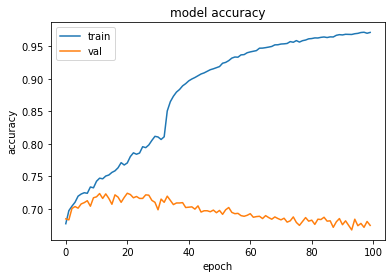

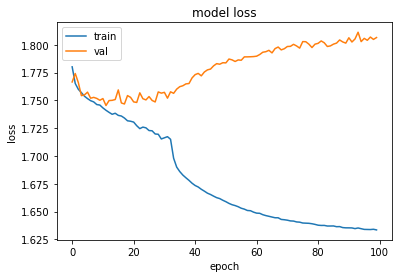

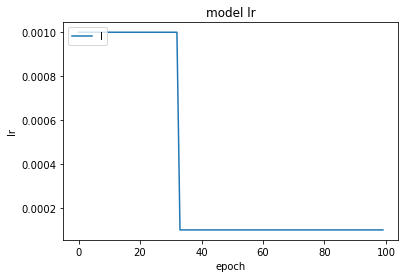

In [7]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(hist.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

In [8]:
imagen = layers.Input((45, 60, 3),name='imagen')

net = Conv2D(filters=32, kernel_size=(11, 11),strides = 4, padding='same')(imagen)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), padding='same')(net)

net = Conv2D(filters=64, kernel_size=(5, 5),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Conv2D(filters=128, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=128, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=64, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Flatten()(net)

net = Dense(units=256, activation='relu')(net)
net = Dropout(0.1)(net)
net = Dense(units=128, activation='relu')(net)
net = Dropout(0.1)(net)
net = Dense(units=7, activation='softmax')(net)

model1 = Model(inputs = imagen, outputs = net)
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imagen (InputLayer)          [(None, 45, 60, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 15, 32)        11648     
_________________________________________________________________
activation_5 (Activation)    (None, 12, 15, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 5, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 5, 64)          51264     
_________________________________________________________________
activation_6 (Activation)    (None, 4, 5, 64)          0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 3, 64)          0   

In [9]:
from keras.optimizers import Adam 
opt = Adam(learning_rate = 0.1)

model1.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])

callback = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, min_lr=0.00001)

hist1 = model1.fit({'imagen':x_trainImg},y_train.toarray(),batch_size = 2, validation_data = (x_valImg,y_val.toarray()),epochs = 100,callbacks = [callback])

Epoch 1/100
3505/3505 [==============================] - 15s 4ms/step - loss: 1.7907 - accuracy: 0.6738 - val_loss: 1.7844 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 2/100
3505/3505 [==============================] - 15s 4ms/step - loss: 1.7767 - accuracy: 0.6786 - val_loss: 1.7757 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 3/100
3505/3505 [==============================] - 15s 4ms/step - loss: 1.7694 - accuracy: 0.6856 - val_loss: 1.7664 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 4/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7651 - accuracy: 0.6926 - val_loss: 1.7724 - val_accuracy: 0.6670 - lr: 0.0010
Epoch 5/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7631 - accuracy: 0.6977 - val_loss: 1.7617 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 6/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7601 - accuracy: 0.7049 - val_loss: 1.7659 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 7/100
3505/3505 [=======================

Epoch 52/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.6868 - accuracy: 0.8700 - val_loss: 1.7680 - val_accuracy: 0.7069 - lr: 1.0000e-04
Epoch 53/100
3505/3505 [==============================] - 15s 4ms/step - loss: 1.6865 - accuracy: 0.8740 - val_loss: 1.7687 - val_accuracy: 0.7054 - lr: 1.0000e-04
Epoch 54/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.6849 - accuracy: 0.8752 - val_loss: 1.7684 - val_accuracy: 0.7059 - lr: 1.0000e-04
Epoch 55/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.6839 - accuracy: 0.8780 - val_loss: 1.7679 - val_accuracy: 0.7069 - lr: 1.0000e-04
Epoch 56/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.6831 - accuracy: 0.8786 - val_loss: 1.7682 - val_accuracy: 0.7099 - lr: 1.0000e-04
Epoch 57/100
3505/3505 [==============================] - 15s 4ms/step - loss: 1.6814 - accuracy: 0.8827 - val_loss: 1.7714 - val_accuracy: 0.7124 - lr: 1.0000e-04
Epoch 58/100
350

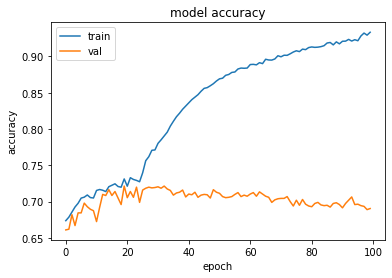

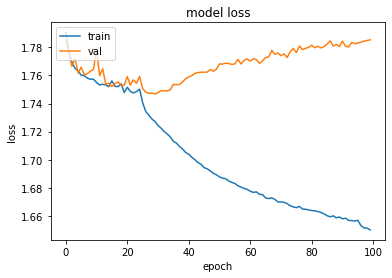

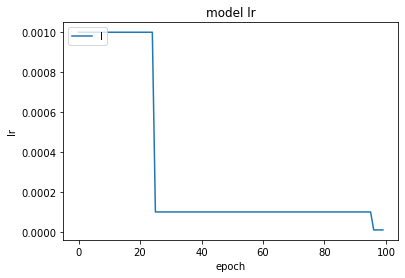

In [10]:
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(hist1.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

In [11]:
imagen = layers.Input((45, 60, 3),name='imagen')

net = Conv2D(filters=4, kernel_size=(11, 11),strides = 4, padding='same')(imagen)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), padding='same')(net)

net = Conv2D(filters=8, kernel_size=(5, 5),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Conv2D(filters=32, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=32, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=16, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Flatten()(net)

net = Dense(units=256, activation='relu')(net)
net = Dropout(0.1)(net)
net = Dense(units=128, activation='relu')(net)
net = Dropout(0.1)(net)
net = Dense(units=7, activation='softmax')(net)

model2 = Model(inputs = imagen, outputs = net)
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imagen (InputLayer)          [(None, 45, 60, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 15, 4)         1456      
_________________________________________________________________
activation_10 (Activation)   (None, 12, 15, 4)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 5, 4)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 5, 8)           808       
_________________________________________________________________
activation_11 (Activation)   (None, 4, 5, 8)           0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 3, 8)           0   

In [12]:
from keras.optimizers import Adam 
opt = Adam(learning_rate = 0.1)

model2.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])

callback = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, min_lr=0.00001)

hist2 = model2.fit({'imagen':x_trainImg},y_train.toarray(),batch_size = 2, validation_data = (x_valImg,y_val.toarray()),epochs = 100,callbacks = [callback])

Epoch 1/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7829 - accuracy: 0.6799 - val_loss: 1.7768 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 2/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7716 - accuracy: 0.6840 - val_loss: 1.7705 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 3/100
3505/3505 [==============================] - 15s 4ms/step - loss: 1.7676 - accuracy: 0.6870 - val_loss: 1.7630 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 4/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7622 - accuracy: 0.6996 - val_loss: 1.7707 - val_accuracy: 0.6895 - lr: 0.0010
Epoch 5/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7616 - accuracy: 0.6964 - val_loss: 1.7638 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 6/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7599 - accuracy: 0.7010 - val_loss: 1.7625 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 7/100
3505/3505 [=======================

Epoch 52/100
3505/3505 [==============================] - 15s 4ms/step - loss: 1.7178 - accuracy: 0.7934 - val_loss: 1.7565 - val_accuracy: 0.7104 - lr: 1.0000e-04
Epoch 53/100
3505/3505 [==============================] - 15s 4ms/step - loss: 1.7172 - accuracy: 0.7934 - val_loss: 1.7557 - val_accuracy: 0.7094 - lr: 1.0000e-04
Epoch 54/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7162 - accuracy: 0.7979 - val_loss: 1.7569 - val_accuracy: 0.7084 - lr: 1.0000e-04
Epoch 55/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7163 - accuracy: 0.7974 - val_loss: 1.7566 - val_accuracy: 0.7134 - lr: 1.0000e-04
Epoch 56/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7149 - accuracy: 0.8004 - val_loss: 1.7581 - val_accuracy: 0.7119 - lr: 1.0000e-04
Epoch 57/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7143 - accuracy: 0.8030 - val_loss: 1.7593 - val_accuracy: 0.7089 - lr: 1.0000e-04
Epoch 58/100
350

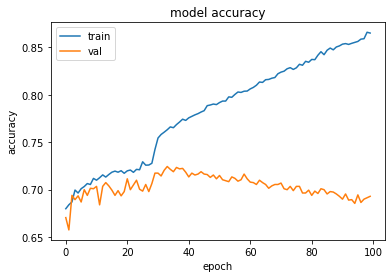

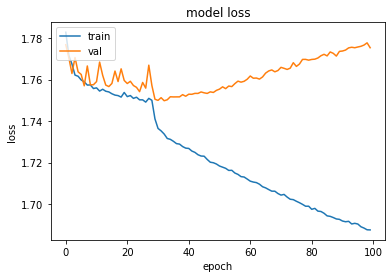

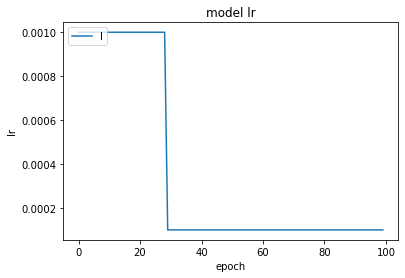

In [13]:
# summarize history for accuracy
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(hist2.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

In [14]:
imagen = layers.Input((45, 60, 3),name='imagen')

net = Conv2D(filters=2, kernel_size=(11, 11),strides = 4, padding='same')(imagen)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), padding='same')(net)

net = Conv2D(filters=8, kernel_size=(5, 5),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Conv2D(filters=16, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=16, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=2, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Flatten()(net)

net = Dense(units=256, activation='relu')(net)
net = Dropout(0.1)(net)
net = Dense(units=128, activation='relu')(net)
net = Dropout(0.1)(net)
net = Dense(units=7, activation='softmax')(net)

model3 = Model(inputs = imagen, outputs = net)
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imagen (InputLayer)          [(None, 45, 60, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 15, 2)         728       
_________________________________________________________________
activation_15 (Activation)   (None, 12, 15, 2)         0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 5, 2)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 5, 8)           408       
_________________________________________________________________
activation_16 (Activation)   (None, 4, 5, 8)           0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 3, 8)           0   

In [15]:
from keras.optimizers import Adam 
opt = Adam(learning_rate = 0.1)

model3.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])

callback = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, min_lr=0.00001)

hist3 = model3.fit({'imagen':x_trainImg},y_train.toarray(),batch_size = 2, validation_data = (x_valImg,y_val.toarray()),epochs = 100,callbacks = [callback])

Epoch 1/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7852 - accuracy: 0.6759 - val_loss: 1.7737 - val_accuracy: 0.6730 - lr: 0.0010
Epoch 2/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7699 - accuracy: 0.6863 - val_loss: 1.7646 - val_accuracy: 0.6915 - lr: 0.0010
Epoch 3/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7646 - accuracy: 0.6939 - val_loss: 1.7667 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 4/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7624 - accuracy: 0.6966 - val_loss: 1.7614 - val_accuracy: 0.6955 - lr: 0.0010
Epoch 5/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7605 - accuracy: 0.6993 - val_loss: 1.7656 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7594 - accuracy: 0.7060 - val_loss: 1.7588 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 7/100
3505/3505 [=======================

3505/3505 [==============================] - 14s 4ms/step - loss: 1.7241 - accuracy: 0.7856 - val_loss: 1.7607 - val_accuracy: 0.7064 - lr: 1.0000e-04
Epoch 52/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7229 - accuracy: 0.7872 - val_loss: 1.7640 - val_accuracy: 0.6995 - lr: 1.0000e-04
Epoch 53/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7231 - accuracy: 0.7852 - val_loss: 1.7638 - val_accuracy: 0.7014 - lr: 1.0000e-04
Epoch 54/100
3505/3505 [==============================] - 15s 4ms/step - loss: 1.7198 - accuracy: 0.7937 - val_loss: 1.7636 - val_accuracy: 0.7039 - lr: 1.0000e-05
Epoch 55/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7185 - accuracy: 0.7974 - val_loss: 1.7641 - val_accuracy: 0.7029 - lr: 1.0000e-05
Epoch 56/100
3505/3505 [==============================] - 14s 4ms/step - loss: 1.7183 - accuracy: 0.7961 - val_loss: 1.7643 - val_accuracy: 0.7024 - lr: 1.0000e-05
Epoch 57/100
3505/3505 [=====

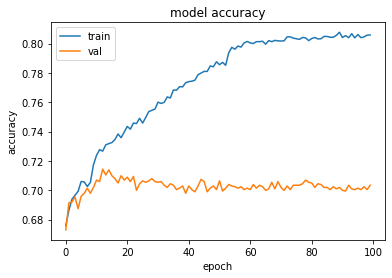

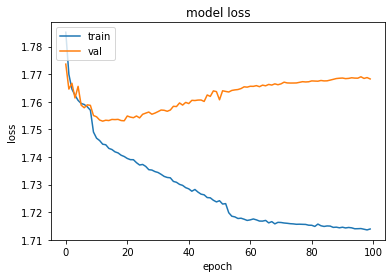

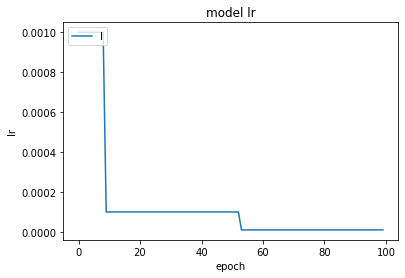

In [16]:
# summarize history for accuracy
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(hist3.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

# Modelos ResNET

In [17]:
def res_block_first(input_layer,filters=4):
    
    #Primera capa
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input_layer)
    aux_net=BatchNormalization()(net)
    
    #conexión directa
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(aux_net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    
    #Shortcut
    net=Add()([aux_net,net])
    
    net=Activation("relu")(net)
    net=MaxPooling2D()(net)
    
    return net

def res_block(input_layer,filters=16, kern = 3):
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(input_layer)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(net)
    net=BatchNormalization()(net)
    net = Dropout(0.2)(net)
    
    #Shortcut
    net=Add()([input_layer,net])
    net=Activation("relu")(net)
    
    return net

def res_block_dec(input_layer,filters=32, kern = 3):
    
    input_layer=MaxPooling2D()(input_layer)
    net=Conv2D(filters=filters, kernel_size=(1, 1), padding='same')(input_layer)
    aux_net=BatchNormalization()(net)
    
    #conexión directa
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(input_layer)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(net)
    net=BatchNormalization()(net)
    net=Add()([aux_net,net])
    net=Activation("relu")(net)
    
    return net

In [18]:
imagen = layers.Input((45, 60, 3),name='imagen')

net=res_block_first(imagen,filters=2)
net=res_block(net,filters=2)
net=res_block(net,filters=2)
net=res_block(net,filters=2)
net=res_block_dec(net,filters=4)
net=res_block(net,filters=4, kern = 10)
net=res_block(net,filters=4, kern = 10)
net=res_block(net,filters=4, kern = 10)
net=res_block_dec(net,filters=16)
net=res_block(net,filters=16)
net=res_block(net,filters=16)
net=res_block(net,filters=16)

net = AveragePooling2D() (net)

net=Flatten()(net)

net=Dense(units=256, activation='relu')(net)
net=Dropout(0.1)(net)
net=Dense(units=256, activation='relu')(net)
net=Dropout(0.1)(net)
net = Dense(units=7, activation='softmax')(net)

modelR = Model(inputs = imagen, outputs = net)
modelR.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imagen (InputLayer)             [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 45, 60, 2)    56          imagen[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 45, 60, 2)    8           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 45, 60, 2)    38          batch_normalization[0][0]        
____________________________________________________________________________________________

In [19]:
from keras.optimizers import Adam 
opt = Adam(learning_rate = 0.1)

modelR.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])

callback = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, min_lr=0.00001)

histR = modelR.fit({'imagen':x_trainImg},y_train.toarray(),batch_size = 2, validation_data = (x_valImg,y_val.toarray()),epochs = 100,callbacks = [callback])

Epoch 1/100
3505/3505 [==============================] - 58s 17ms/step - loss: 1.8067 - accuracy: 0.6723 - val_loss: 1.8019 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 2/100
3505/3505 [==============================] - 57s 16ms/step - loss: 1.7878 - accuracy: 0.6742 - val_loss: 1.7845 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 3/100
3505/3505 [==============================] - 57s 16ms/step - loss: 1.7825 - accuracy: 0.6746 - val_loss: 1.7820 - val_accuracy: 0.6640 - lr: 0.0010
Epoch 4/100
3505/3505 [==============================] - 57s 16ms/step - loss: 1.7804 - accuracy: 0.6743 - val_loss: 1.7849 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 5/100
3505/3505 [==============================] - 57s 16ms/step - loss: 1.7766 - accuracy: 0.6742 - val_loss: 1.7809 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 6/100
3505/3505 [==============================] - 58s 16ms/step - loss: 1.7755 - accuracy: 0.6769 - val_loss: 1.7815 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 7/100
3505/3505 [=================

Epoch 52/100
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7121 - accuracy: 0.8107 - val_loss: 1.7536 - val_accuracy: 0.7154 - lr: 1.0000e-04
Epoch 53/100
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7127 - accuracy: 0.8124 - val_loss: 1.7541 - val_accuracy: 0.7159 - lr: 1.0000e-04
Epoch 54/100
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7118 - accuracy: 0.8111 - val_loss: 1.7543 - val_accuracy: 0.7144 - lr: 1.0000e-04
Epoch 55/100
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7123 - accuracy: 0.8150 - val_loss: 1.7556 - val_accuracy: 0.7159 - lr: 1.0000e-04
Epoch 56/100
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7109 - accuracy: 0.8175 - val_loss: 1.7553 - val_accuracy: 0.7164 - lr: 1.0000e-04
Epoch 57/100
3505/3505 [==============================] - 54s 15ms/step - loss: 1.7093 - accuracy: 0.8185 - val_loss: 1.7554 - val_accuracy: 0.7184 - lr: 1.0000e-04
Epoch 58/1

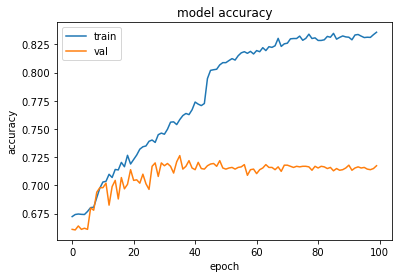

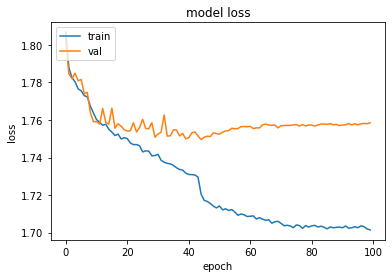

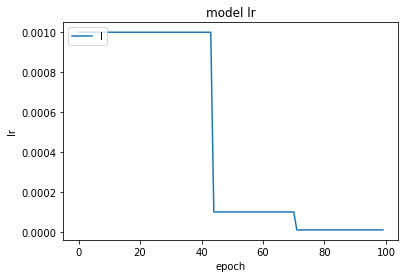

In [20]:
# summarize history for accuracy
plt.plot(histR.history['accuracy'])
plt.plot(histR.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histR.history['loss'])
plt.plot(histR.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(histR.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

In [22]:
imagen = layers.Input((45, 60, 3),name='imagen')

net=res_block_first(imagen,filters=2)
net=res_block(net,filters=2)
net=res_block(net,filters=2)
net=res_block(net,filters=2)
net=res_block_dec(net,filters=4)
net=res_block(net,filters=4, kern = 10)
net=res_block(net,filters=4, kern = 10)
net=res_block(net,filters=4, kern = 10)
net=res_block_dec(net,filters=8)
net=res_block(net,filters=8)
net=res_block(net,filters=8)
net=res_block(net,filters=8)

net = AveragePooling2D() (net)

net=Flatten()(net)

net=Dense(units=128, activation='relu')(net)
net=Dropout(0.1)(net)
net=Dense(units=128, activation='relu')(net)
net=Dropout(0.1)(net)
net = Dense(units=7, activation='softmax')(net)

modelR1 = Model(inputs = imagen, outputs = net)
modelR1.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imagen (InputLayer)             [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 45, 60, 2)    56          imagen[0][0]                     
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 45, 60, 2)    8           conv2d_88[0][0]                  
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 45, 60, 2)    38          batch_normalization_68[0][0]     
____________________________________________________________________________________________

In [23]:
from keras.optimizers import Adam 
opt = Adam(learning_rate = 0.1)

modelR1.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])

callback = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, min_lr=0.00001)

histR1 = modelR1.fit({'imagen':x_trainImg},y_train.toarray(),batch_size = 2, validation_data = (x_valImg,y_val.toarray()),epochs = 60,callbacks = [callback])

Epoch 1/60
3505/3505 [==============================] - 55s 16ms/step - loss: 1.8005 - accuracy: 0.6732 - val_loss: 1.7875 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 2/60
3505/3505 [==============================] - 54s 16ms/step - loss: 1.7852 - accuracy: 0.6749 - val_loss: 1.7823 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 3/60
3505/3505 [==============================] - 54s 15ms/step - loss: 1.7784 - accuracy: 0.6738 - val_loss: 1.7798 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 4/60
3505/3505 [==============================] - 53s 15ms/step - loss: 1.7736 - accuracy: 0.6752 - val_loss: 1.7725 - val_accuracy: 0.6730 - lr: 0.0010
Epoch 5/60
3505/3505 [==============================] - 54s 16ms/step - loss: 1.7672 - accuracy: 0.6920 - val_loss: 1.7655 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 6/60
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7649 - accuracy: 0.6877 - val_loss: 1.7640 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 7/60
3505/3505 [========================

3505/3505 [==============================] - 54s 15ms/step - loss: 1.7361 - accuracy: 0.7485 - val_loss: 1.7473 - val_accuracy: 0.7164 - lr: 1.0000e-05
Epoch 52/60
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7359 - accuracy: 0.7538 - val_loss: 1.7475 - val_accuracy: 0.7179 - lr: 1.0000e-05
Epoch 53/60
3505/3505 [==============================] - 54s 15ms/step - loss: 1.7365 - accuracy: 0.7521 - val_loss: 1.7472 - val_accuracy: 0.7139 - lr: 1.0000e-05
Epoch 54/60
3505/3505 [==============================] - 54s 15ms/step - loss: 1.7353 - accuracy: 0.7492 - val_loss: 1.7474 - val_accuracy: 0.7179 - lr: 1.0000e-05
Epoch 55/60
3505/3505 [==============================] - 54s 15ms/step - loss: 1.7359 - accuracy: 0.7512 - val_loss: 1.7471 - val_accuracy: 0.7174 - lr: 1.0000e-05
Epoch 56/60
3505/3505 [==============================] - 54s 15ms/step - loss: 1.7352 - accuracy: 0.7474 - val_loss: 1.7469 - val_accuracy: 0.7184 - lr: 1.0000e-05
Epoch 57/60
3505/3505 [=====

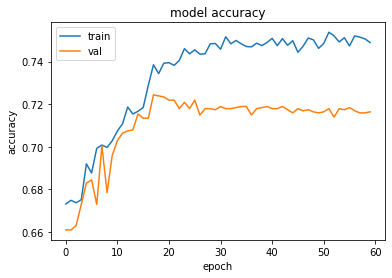

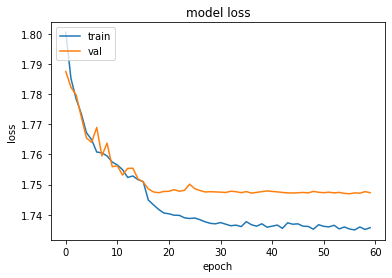

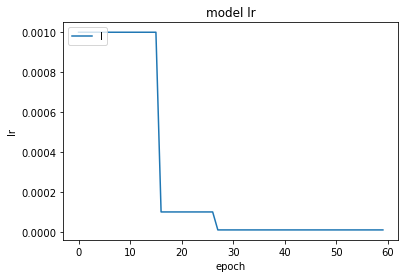

In [24]:
# summarize history for accuracy
plt.plot(histR1.history['accuracy'])
plt.plot(histR1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histR1.history['loss'])
plt.plot(histR1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(histR1.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

In [25]:
imagen = layers.Input((45, 60, 3),name='imagen')

net=res_block_first(imagen,filters=2)
net=res_block(net,filters=2)
net=res_block(net,filters=2)
net=res_block(net,filters=2)
net=res_block_dec(net,filters=8)
net=res_block(net,filters=8, kern = 10)
net=res_block(net,filters=8, kern = 10)
net=res_block(net,filters=8, kern = 10)
net=res_block_dec(net,filters=16)
net=res_block(net,filters=16)
net=res_block(net,filters=16)
net=res_block(net,filters=16)

net = AveragePooling2D() (net)

net=Flatten()(net)

net=Dense(units=128, activation='relu')(net)
net=Dropout(0.1)(net)
net=Dense(units=128, activation='relu')(net)
net=Dropout(0.1)(net)
net = Dense(units=7, activation='softmax')(net)

modelR2 = Model(inputs = imagen, outputs = net)
modelR2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imagen (InputLayer)             [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 45, 60, 2)    56          imagen[0][0]                     
__________________________________________________________________________________________________
batch_normalization_107 (BatchN (None, 45, 60, 2)    8           conv2d_127[0][0]                 
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 45, 60, 2)    38          batch_normalization_107[0][0]    
____________________________________________________________________________________________

In [26]:
from keras.optimizers import Adam 
opt = Adam(learning_rate = 0.1)

modelR2.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])

callback = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, min_lr=0.00001)

histR2 = modelR2.fit({'imagen':x_trainImg},y_train.toarray(),batch_size = 2, validation_data = (x_valImg,y_val.toarray()),epochs = 60,callbacks = [callback])

Epoch 1/60
3505/3505 [==============================] - 56s 16ms/step - loss: 1.7949 - accuracy: 0.6736 - val_loss: 1.7836 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 2/60
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7779 - accuracy: 0.6793 - val_loss: 1.7689 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 3/60
3505/3505 [==============================] - 56s 16ms/step - loss: 1.7735 - accuracy: 0.6797 - val_loss: 1.7699 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 4/60
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7673 - accuracy: 0.6890 - val_loss: 1.7699 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 5/60
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7647 - accuracy: 0.6894 - val_loss: 1.7613 - val_accuracy: 0.6965 - lr: 0.0010
Epoch 6/60
3505/3505 [==============================] - 55s 16ms/step - loss: 1.7618 - accuracy: 0.6930 - val_loss: 1.7557 - val_accuracy: 0.7024 - lr: 0.0010
Epoch 7/60
3505/3505 [========================

3505/3505 [==============================] - 54s 15ms/step - loss: 1.7020 - accuracy: 0.8347 - val_loss: 1.7585 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 53/60
3505/3505 [==============================] - 54s 15ms/step - loss: 1.7015 - accuracy: 0.8394 - val_loss: 1.7525 - val_accuracy: 0.7254 - lr: 0.0010
Epoch 54/60
3505/3505 [==============================] - 54s 16ms/step - loss: 1.7015 - accuracy: 0.8324 - val_loss: 1.7525 - val_accuracy: 0.7264 - lr: 0.0010
Epoch 55/60
3505/3505 [==============================] - 54s 15ms/step - loss: 1.6991 - accuracy: 0.8408 - val_loss: 1.7600 - val_accuracy: 0.7089 - lr: 0.0010
Epoch 56/60
3505/3505 [==============================] - 54s 15ms/step - loss: 1.6989 - accuracy: 0.8412 - val_loss: 1.7555 - val_accuracy: 0.7254 - lr: 0.0010
Epoch 57/60
3505/3505 [==============================] - 55s 16ms/step - loss: 1.6942 - accuracy: 0.8528 - val_loss: 1.7524 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 58/60
3505/3505 [=============================

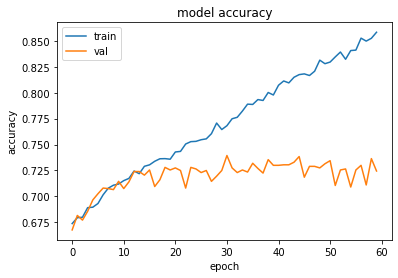

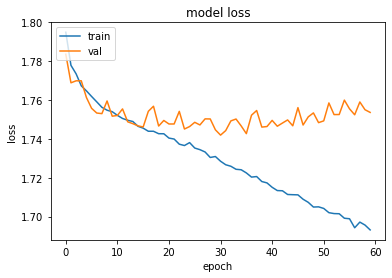

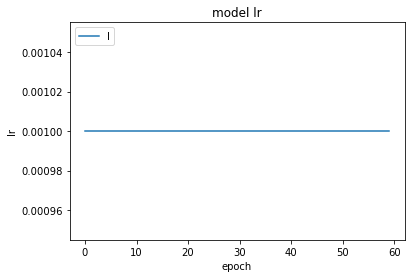

In [27]:
# summarize history for accuracy
plt.plot(histR2.history['accuracy'])
plt.plot(histR2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histR2.history['loss'])
plt.plot(histR2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(histR2.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

# Modelo Inception

In [29]:
def inception_block(input_layer,filters=64):
    tower_1 = Conv2D(filters, (1,1), padding='same', activation='relu')(input_layer)
    tower_1 = Conv2D(filters, (3,3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(filters, (1,1), padding='same', activation='relu')(input_layer)
    tower_2 = Conv2D(filters, (5,5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
    tower_3 = Conv2D(filters, (1,1), padding='same', activation='relu')(tower_3)
    output = layers.Concatenate()([tower_1, tower_2, tower_3])
    return output

In [35]:
imagen = layers.Input((45, 60, 3),name='imagen')

net = Conv2D(4, kernel_size = (7,7), strides = 2)(imagen)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)
net = Conv2D(8, kernel_size = (3,3), strides = 1)(net)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,16)
net = inception_block(net,16)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,32)
net = inception_block(net,32)
net = inception_block(net,32)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = AveragePooling2D(pool_size = (1,2), strides = 1)(net)
net = Flatten()(net)
net = Dropout(0.4)(net)
net = Dense(64, activation = 'relu')(net)
net = Dense(7, activation = 'softmax')(net)

modelInc = Model(inputs = imagen, outputs = net)
modelInc.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imagen (InputLayer)             [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_276 (Conv2D)             (None, 20, 27, 4)    592         imagen[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_62 (MaxPooling2D) (None, 10, 14, 4)    0           conv2d_276[0][0]                 
__________________________________________________________________________________________________
conv2d_277 (Conv2D)             (None, 8, 12, 8)     296         max_pooling2d_62[0][0]           
____________________________________________________________________________________________

In [36]:
from keras.optimizers import Adam 
opt = Adam(learning_rate = 0.1)

modelInc.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])

callback = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, min_lr=0.00001)

histInc = modelInc.fit({'imagen':x_trainImg},y_train.toarray(),batch_size = 2, validation_data = (x_valImg,y_val.toarray()),epochs = 60,callbacks = [callback])

Epoch 1/60
3505/3505 [==============================] - 31s 9ms/step - loss: 1.7815 - accuracy: 0.6762 - val_loss: 1.7957 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 2/60
3505/3505 [==============================] - 31s 9ms/step - loss: 1.7673 - accuracy: 0.6883 - val_loss: 1.7662 - val_accuracy: 0.6730 - lr: 0.0010
Epoch 3/60
3505/3505 [==============================] - 31s 9ms/step - loss: 1.7635 - accuracy: 0.6912 - val_loss: 1.7618 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 4/60
3505/3505 [==============================] - 30s 9ms/step - loss: 1.7619 - accuracy: 0.6976 - val_loss: 1.7561 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 5/60
3505/3505 [==============================] - 30s 8ms/step - loss: 1.7579 - accuracy: 0.7049 - val_loss: 1.7592 - val_accuracy: 0.6895 - lr: 0.0010
Epoch 6/60
3505/3505 [==============================] - 30s 9ms/step - loss: 1.7576 - accuracy: 0.7047 - val_loss: 1.7599 - val_accuracy: 0.6910 - lr: 0.0010
Epoch 7/60
3505/3505 [==============================

Epoch 52/60
3505/3505 [==============================] - 29s 8ms/step - loss: 1.6656 - accuracy: 0.9107 - val_loss: 1.7784 - val_accuracy: 0.6990 - lr: 1.0000e-04
Epoch 53/60
3505/3505 [==============================] - 30s 9ms/step - loss: 1.6647 - accuracy: 0.9107 - val_loss: 1.7796 - val_accuracy: 0.6960 - lr: 1.0000e-04
Epoch 54/60
3505/3505 [==============================] - 30s 8ms/step - loss: 1.6626 - accuracy: 0.9151 - val_loss: 1.7825 - val_accuracy: 0.6885 - lr: 1.0000e-04
Epoch 55/60
3505/3505 [==============================] - 31s 9ms/step - loss: 1.6616 - accuracy: 0.9171 - val_loss: 1.7850 - val_accuracy: 0.6840 - lr: 1.0000e-04
Epoch 56/60
3505/3505 [==============================] - 30s 8ms/step - loss: 1.6601 - accuracy: 0.9183 - val_loss: 1.7862 - val_accuracy: 0.6820 - lr: 1.0000e-04
Epoch 57/60
3505/3505 [==============================] - 30s 9ms/step - loss: 1.6589 - accuracy: 0.9217 - val_loss: 1.7832 - val_accuracy: 0.6940 - lr: 1.0000e-04
Epoch 58/60
3505/3505 

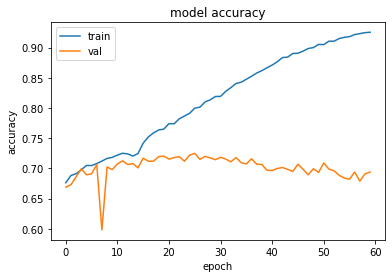

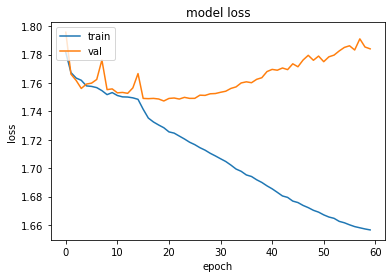

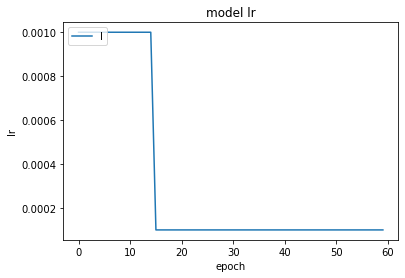

In [37]:
# summarize history for accuracy
plt.plot(histInc.history['accuracy'])
plt.plot(histInc.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histInc.history['loss'])
plt.plot(histInc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(histInc.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

In [41]:
imagen = layers.Input((45, 60, 3),name='imagen')

net = Conv2D(2, kernel_size = (7,7), strides = 2)(imagen)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)
net = Conv2D(4, kernel_size = (3,3), strides = 1)(net)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,8)
net = inception_block(net,8)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,16)
net = inception_block(net,16)
net = inception_block(net,16)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = AveragePooling2D(pool_size = (1,2), strides = 1)(net)
net = Flatten()(net)
net = Dropout(0.4)(net)
net = Dense(64, activation = 'relu')(net)
net = Dense(7, activation = 'softmax')(net)

modelInc1 = Model(inputs = imagen, outputs = net)
modelInc1.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imagen (InputLayer)             [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_384 (Conv2D)             (None, 20, 27, 2)    296         imagen[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_98 (MaxPooling2D) (None, 10, 14, 2)    0           conv2d_384[0][0]                 
__________________________________________________________________________________________________
conv2d_385 (Conv2D)             (None, 8, 12, 4)     76          max_pooling2d_98[0][0]           
___________________________________________________________________________________________

In [42]:
from keras.optimizers import Adam 
opt = Adam(learning_rate = 0.1)

modelInc1.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])

callback = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, min_lr=0.00001)

histInc1 = modelInc1.fit({'imagen':x_trainImg},y_train.toarray(),batch_size = 2, validation_data = (x_valImg,y_val.toarray()),epochs = 60,callbacks = [callback])

Epoch 1/60
3505/3505 [==============================] - 29s 8ms/step - loss: 1.7839 - accuracy: 0.6767 - val_loss: 1.7867 - val_accuracy: 0.6410 - lr: 0.0010
Epoch 2/60
3505/3505 [==============================] - 29s 8ms/step - loss: 1.7715 - accuracy: 0.6867 - val_loss: 1.7706 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 3/60
3505/3505 [==============================] - 30s 8ms/step - loss: 1.7668 - accuracy: 0.6837 - val_loss: 1.7690 - val_accuracy: 0.6695 - lr: 0.0010
Epoch 4/60
3505/3505 [==============================] - 28s 8ms/step - loss: 1.7642 - accuracy: 0.6916 - val_loss: 1.7615 - val_accuracy: 0.6865 - lr: 0.0010
Epoch 5/60
3505/3505 [==============================] - 30s 9ms/step - loss: 1.7616 - accuracy: 0.6933 - val_loss: 1.7605 - val_accuracy: 0.6915 - lr: 0.0010
Epoch 6/60
3505/3505 [==============================] - 30s 8ms/step - loss: 1.7614 - accuracy: 0.6997 - val_loss: 1.7597 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 7/60
3505/3505 [==============================

Epoch 52/60
3505/3505 [==============================] - 30s 9ms/step - loss: 1.7159 - accuracy: 0.8033 - val_loss: 1.7608 - val_accuracy: 0.6995 - lr: 1.0000e-04
Epoch 53/60
3505/3505 [==============================] - 29s 8ms/step - loss: 1.7142 - accuracy: 0.8066 - val_loss: 1.7623 - val_accuracy: 0.7024 - lr: 1.0000e-04
Epoch 54/60
3505/3505 [==============================] - 29s 8ms/step - loss: 1.7139 - accuracy: 0.8071 - val_loss: 1.7634 - val_accuracy: 0.6985 - lr: 1.0000e-04
Epoch 55/60
3505/3505 [==============================] - 30s 9ms/step - loss: 1.7122 - accuracy: 0.8101 - val_loss: 1.7636 - val_accuracy: 0.6960 - lr: 1.0000e-04
Epoch 56/60
3505/3505 [==============================] - 29s 8ms/step - loss: 1.7108 - accuracy: 0.8124 - val_loss: 1.7635 - val_accuracy: 0.6975 - lr: 1.0000e-04
Epoch 57/60
3505/3505 [==============================] - 29s 8ms/step - loss: 1.7102 - accuracy: 0.8171 - val_loss: 1.7632 - val_accuracy: 0.7024 - lr: 1.0000e-04
Epoch 58/60
3505/3505 

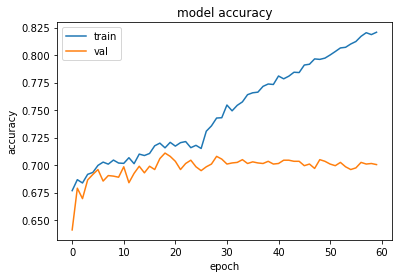

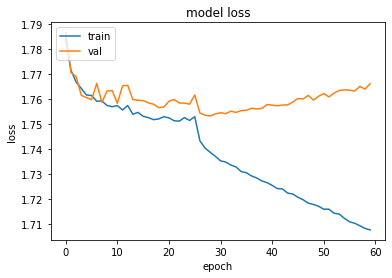

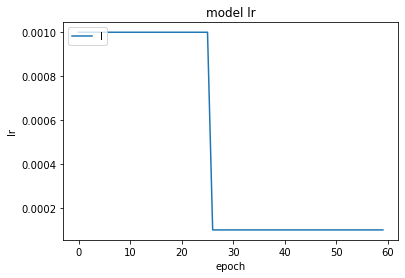

In [43]:
# summarize history for accuracy
plt.plot(histInc1.history['accuracy'])
plt.plot(histInc1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histInc1.history['loss'])
plt.plot(histInc1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(histInc1.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

# Imprimimos resultados

In [45]:
resultados = pd.DataFrame()

resultados = {
    'Tipo': AlexNet
    'Parametros': 142,983
    'Top Validation': max(hist.history['val_accuracy'])
    'Epoch': hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))
}

In [66]:
resultados = pd.DataFrame(columns = ['Tipo','Parametros','Top Validation','Epoch'])

resultados.append([{
    'Tipo': 'AlexNet',
    'Parametros': '424,967',
    'Top Validation': max(hist1.history['val_accuracy']),
    'Epoch': hist1.history['val_accuracy'].index(max(hist1.history['val_accuracy']))
},{
    'Tipo': 'AlexNet',
    'Parametros': '142,983',
    'Top Validation': max(hist.history['val_accuracy']),
    'Epoch': hist.history['val_accuracy'].index(max(hist1.history['val_accuracy']))
},{
    'Tipo': 'AlexNet',
    'Parametros': '60,719',
    'Top Validation': max(hist2.history['val_accuracy']),
    'Epoch': hist2.history['val_accuracy'].index(max(hist2.history['val_accuracy']))
},{
    'Tipo': 'AlexNet',
    'Parametros': '39,993',
    'Top Validation': max(hist3.history['val_accuracy']),
    'Epoch': hist3.history['val_accuracy'].index(max(hist3.history['val_accuracy']))
},{
    'Tipo': 'ResNET',
    'Parametros': '135,091',
    'Top Validation': max(histR.history['val_accuracy']),
    'Epoch': histR.history['val_accuracy'].index(max(histR.history['val_accuracy']))
},{
    'Tipo': 'ResNET',
    'Parametros': '46,507',
    'Top Validation': max(histR1.history['val_accuracy']),
    'Epoch': histR1.history['val_accuracy'].index(max(histR1.history['val_accuracy']))
},{
    'Tipo': 'ResNET',
    'Parametros': '117,543',
    'Top Validation': max(histR2.history['val_accuracy']),
    'Epoch': histR2.history['val_accuracy'].index(max(histR2.history['val_accuracy']))
},{
    'Tipo': 'Inception',
    'Parametros': '155,775',
    'Top Validation': max(histInc.history['val_accuracy']),
    'Epoch': histInc.history['val_accuracy'].index(max(histInc.history['val_accuracy']))
},{
    'Tipo': 'Inception',
    'Parametros': '137,803',
    'Top Validation': max(histInc1.history['val_accuracy']),
    'Epoch': histInc1.history['val_accuracy'].index(max(histInc1.history['val_accuracy']))
}],ignore_index = True)

,Tipo,Parametros,Top Validation,Epoch
0,AlexNet,"424,967",0.721418,19
1,AlexNet,"142,983",0.723914,16
2,AlexNet,"60,719",0.724413,33
3,AlexNet,"39,993",0.714428,12
4,ResNET,"135,091",0.726410,35
5,ResNET,"46,507",0.724413,17
6,ResNET,"117,543",0.739391,30
7,Inception,"155,775",0.724913,25
8,Inception,"137,803",0.710934,18
